# Diffusion maps

#### Author: Ching-Ru Chung, 2019

## Abstract

When we use computer to group some points, an algorithm called k-means clustering is a good choice for us. But this algorithm has a defect that it can't make a good result when the points have complex distribution in data. This semester I saw my senior student's Python code about diffusion map and I conver it into Julia.  
It transform the points with complex form into one with simpler form, which can be treat well by using k-means clustering.  
In the following, I will show how to construct a diffusion map step by step and implement my code.


## Framework

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^d$,construct the diffusion maps by using following steps:

### 1. Define a kernel matrix $K$

Let $K$ be a kernel matrix with entries $ K_{ij}=k(x_{i},x_{j}) $, where $k$ is the Guassian kernel
$$ k(x,y) = \exp(-\frac{\lVert x-y \rVert^2}{\alpha}), $$
and $\sigma$ is a manually picked constant.  

In [1]:
function get_K(X , alpha)
    n = size(X,1) ; # number of points
    K = ones(n,n) ; # the diagonal entries are 1 in kernel matrix
    
    # get components of kernel matrix
    for ii = 1 : n
        for jj = ii+1 : n
            temp = sum((X[ii,:] - X[jj,:]).^2) ;
            K[ii,jj] = exp(-temp/alpha) ;
            K[jj,ii] = K[ii,jj] ; # since k(x,y) = k(y,x)
        end
    end
    
    return K ;
end

get_K (generic function with 1 method)

### 2. Construct a matrix $P'$ that related to diffusion matrix $P$

Diffusion matrix $P$ is defined as $$P=D^{-1}K$$
a matrix that describe the connectivity between two data points, which can be consider as the probability of jumping from one point to another in one step of random walk. Define matrix $P'$ , a symmetric matrix that related to $P$
$$ P'=D^{\frac{1}{2}}PD^{-\frac{1}{2}}=D^{-\frac{1}{2}}KD^{-\frac{1}{2}} $$
where $D$ is a diagonal with its entries are equal to the row sums of $K$ , respectively. it can help us to find real eigenvalue and eigenvector later.

In [2]:
function get_Ppron(K)
    n = size(K,1) ;
    Ppron = zeros(n,n) ;
    Dsq = zeros(n) ; # square root of D on diagonal
    
    for ii = 1 : n
        Dsq[ii] = sqrt(sum(K[ii,:])) ;
    end
    
    # get components of P'
    for ii = 1 : n
        for jj = 1 : n
            # the form of components in P'
            Ppron[ii,jj] = K[ii,jj]/(Dsq[ii]*Dsq[jj]) ;
        end
    end
    
    return Ppron , Dsq ;
end

get_Ppron (generic function with 1 method)

### 3. Find eigenvectors and eigenvalues of $P$

The eigenvalues of $P$ is equal to the eigenvalues of $P'$, which is arrange in descending power.  The eigenvector $v_k$ of $P$ is
$$ v_k = D^{-\frac{1}{2}} v'_k $$ where $v'_k$ is the eigenvector of $P'$

In [85]:
using LinearAlgebra
function get_eig(Ppron , Dsq)
    
    n = size(Ppron , 1) ;
    
    U,S,V = svd(Ppron) ; # U and S contains eigenvectors and eigenvalues repectively 
                         # which is arranged in descending power.
    
    # find eigenvectors of P
    v = zeros(n,n) ;
    for ii = 1 : n
        v[ii,:] = U[ii,:]./Dsq[ii] ;
    end
    
    return S , v ;
end

get_eig (generic function with 1 method)

### 4. Define a diffusion map 

Let $Y$ be a diffusion map, which map corrdinates between data and diffusion space , with its column
$$ Y_i=[\lambda_i v_i] $$
Dimensional reduction is done by neglecting certain dimensions in the diffusion space, since the order of eigenvalue is associated to the importance of relation on the data.

In [169]:
function get_Y(S , v , c)
    n = size(v,1) ;
    Y = zeros(n,c) ;
    
    # get components of diffusion map Y
    for ii = 1 : c
        Y[:,ii] = v[:,ii+1] .* S[ii+1] ;
    end
    
    return Y ;
end

get_Y (generic function with 1 method)

### 5. K-means Clustering

Using k-means method to get the labeling of the datas, here k is a manually select number of groups.

In [170]:
function k_means(Y , cluster) # cluster is the number of groups
    
    n = size(Y,1) ;
    d = size(Y,2) ;
    center = zeros(cluster,d) ;
    
    index = rand(1:n , cluster) ; # Randomly pick the same number of numbers as cluster from 1~n
    group , weight1 = classify(Y , Y[index , :]) ; # find the first weight
    
    center = update_center(Y , group , cluster) ;  # update the center
    group , weight2 = classify(Y , center) ;       # find the next weight
    
    # classify and update repeatly until the weight becomes stabilize.
    time = 1 ;
    while weight1 != weight2
        # replace as previos one
        weight1 = weight2 ;
        
        # update and classify to get a new groups
        center  = update_center(Y , group , cluster) ;
        group , weight2 = classify(Y , center) ;
        
        time += 1 ;
    end
    
    print("The update times = ", time) ; # print the number of executions of while loop.
    
    return group , center ;
end

k_means (generic function with 1 method)

$classify$ function is to classify the points into three groups by comparing the distances between the point and three centers respectively.

In [171]:
function classify(Y , center)
    
    n = size(Y,1) ;
    cluster = size(center,1) ; # number of center
    weight = 0 ;
    group = ones(n) ; # Classify the n points by label as 1 ~ cluster.
    
    for ii = 1 : n
        
        # For all points in Y , find the minimum of distances with centers.
        DistanceMin = sum((Y[ii,:] - center[1,:]).^2) ;
        for jj = 2 : cluster
            
            # Strictly speaking , it is the square of the distance
            distance = sum((Y[ii,:] - center[jj,:]).^2) ;
            
            # If the point is closer to one center than the others,
            # then it will be put in the group belong to the center.
            if DistanceMin > distance
                DistanceMin = distance ;
                group[ii] = jj ;
            end
            
        end
        
        # get weight by summing up all distance between point and center in same group.
        weight += DistanceMin ;
        
    end
    
    return group , weight ;
end

classify (generic function with 1 method)

$update\ center$ function is to reset the centers by finding the centroids from each group.

In [172]:
function update_center(Y , group , cluster)
    n = size(Y,1) ;
    d = size(Y,2) ;
    center = zeros(cluster,d) ;
    num = zeros(cluster) ;
    
    # find new centroids (or geometric center) from each group.
    for ii = 1 : n
        center[Int(group[ii]) , :] += Y[ii,:] ;
        num[Int(group[ii])] += 1 ;
    end
    
    for ii = 1 : cluster
        center[ii,:] ./= num[ii] ;
    end
    
    return center
end

update_center (generic function with 1 method)

In [173]:
function DiffMap(X , sigma , c)
    K = get_K(X , sigma) ;
    Ppron , Dsq = get_Ppron(K) ;
    S , v = get_eig(Ppron , Dsq) ;
    Y = get_Y(S , v , c) ;
    return Y ;
end

DiffMap (generic function with 1 method)

## Implementation

### 1. Load data

In [174]:
using MAT
using PyPlot

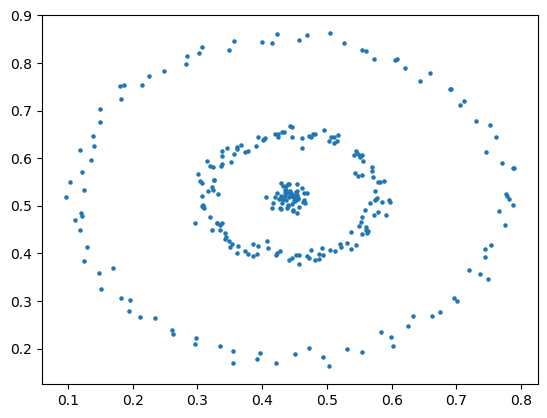

PyObject <matplotlib.collections.PathCollection object at 0x00000000539DD208>

In [175]:
file = matread("Data2.mat")
X = file["data"] ;
scatter(X[:,1] , X[:,2] , s = 5)

### 2. Construct diffusion map

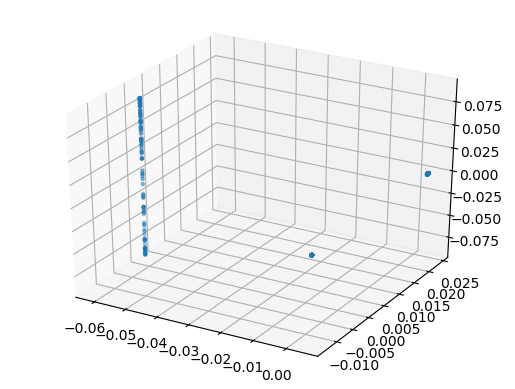

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x0000000054A5D898>

In [176]:
alpha = 0.001 ;
c = 3 ; # the number of eigrnvalues we use

Y = DiffMap(X , alpha , c) ;

# print diffution map
scatter3D(Y[:,1] , Y[:,2] , Y[:,3] , s = 5)

### 3. Use k-means clustering

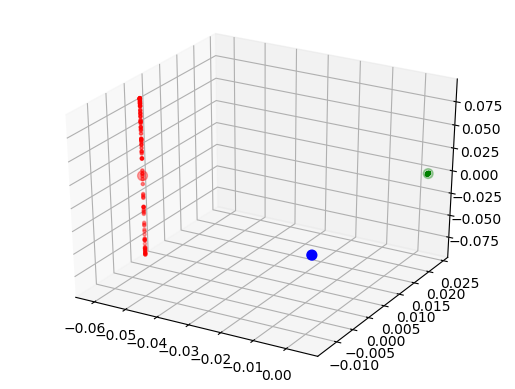

The update times = 3

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x0000000054AF5630>

In [177]:
# it will return the label of points and tell us how many times the center was updated.
cluster = 3 ; # seperate into three groups
group , center = k_means(Y , cluster) ;

# select the color
dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "black" , 5 => "brown" , 6 => "cyan" , 7 => "orange") ;
color = Array{String}(undef, size(group , 1)) ;
for ii = 1 : size(group , 1)
    color[ii] = dict[group[ii]] ;
end

scatter3D(Y[:,1] , Y[:,2] , Y[:,3] , s = 5 , c = color)
scatter3D(center[:,1] , center[:,2] , center[:,3] , s = 50 , c = ["red","green","blue"])

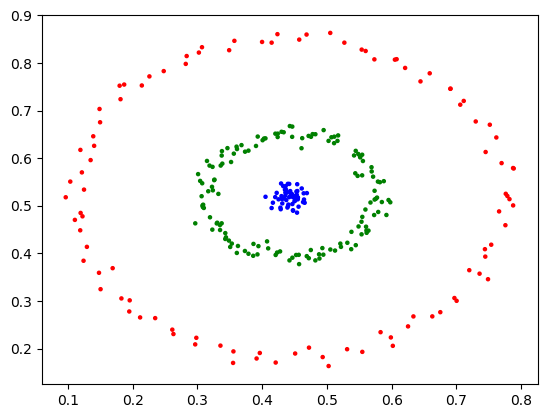

PyObject <matplotlib.collections.PathCollection object at 0x0000000054F00FD0>

In [178]:
# print
scatter(X[:,1] , X[:,2] , s = 5 , c = color)

## Other case

In [91]:
using JLD2
@load "Data.jld2" ;
# select the color
dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "black" , 5 => "brown" , 6 => "cyan" , 7 => "orange") ;

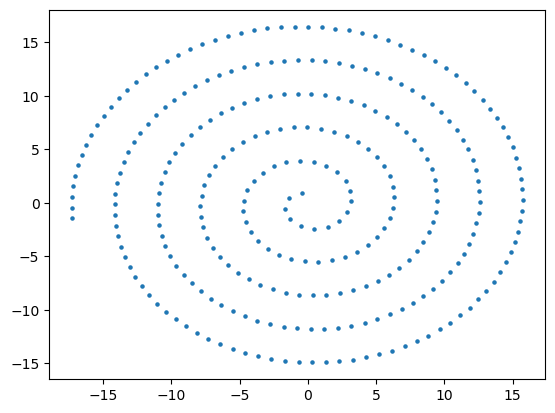

PyObject <matplotlib.collections.PathCollection object at 0x0000000049C35A58>

In [92]:
scatter(data1[:,1] , data1[:,2] , s = 5)

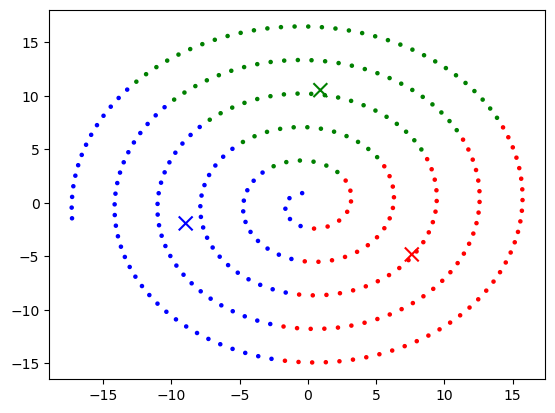

The update times = 14

PyObject <matplotlib.collections.PathCollection object at 0x0000000049D52E10>

In [93]:
group , center = k_means(data1 , cluster) ;

color = Array{String}(undef, size(group , 1)) ;
for ii = 1 : size(group , 1)
    color[ii] = dict[group[ii]] ;
end

# print
scatter(data[:,1] , data[:,2] , s = 5 , c = color)
scatter(center[:,1] , center[:,2] , s = 100 , c = ["red","green","blue"] , marker = "x")

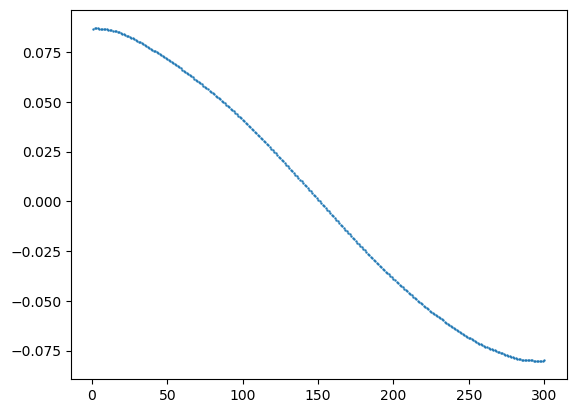

PyObject <matplotlib.collections.PathCollection object at 0x000000005642C7F0>

In [196]:
Yt1 = DiffMap(data1 , 0.04 , 1) ;
scatter(1:300 , Yt1[:,1] , s = 0.5)

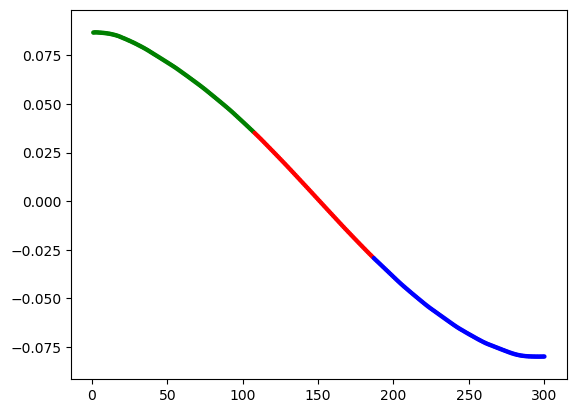

The update times = 15

PyObject <matplotlib.collections.PathCollection object at 0x00000000566C4780>

In [197]:
cluster = 3 ; # seperate into three groups
group , center = k_means(Yt1 , cluster) ;

color = Array{String}(undef, size(group , 1)) ;
for ii = 1 : size(group , 1)
    color[ii] = dict[group[ii]] ;
end

# print
scatter(1:300 , Yt1[:,1] , s = 5 , c = color)

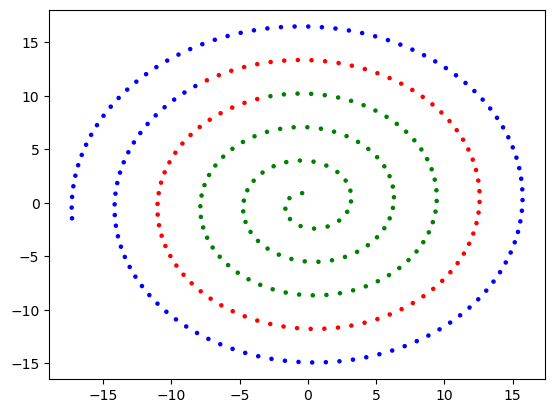

PyObject <matplotlib.collections.PathCollection object at 0x000000005672E710>

In [198]:
scatter(data1[:,1] , data1[:,2] , s = 5 , c = color)

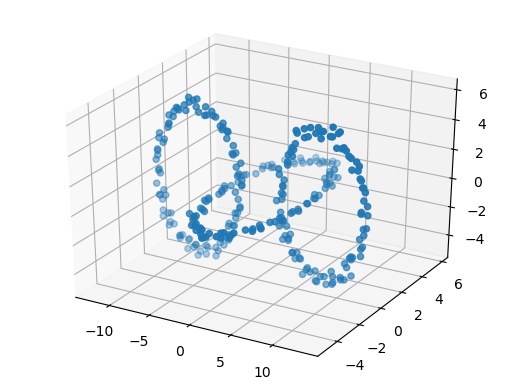

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x0000000056797F60>

In [199]:
scatter3D(data2[:,1] , data2[:,2] , data2[:,3] , s = 20 )

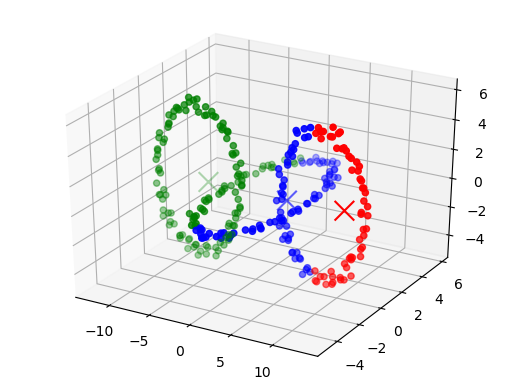

The update times = 7

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x000000005649F2B0>

In [200]:
cluster = 3 ; # seperate into three groups
group , center = k_means(data2 , cluster) ;

color = Array{String}(undef, size(group , 1)) ;
for ii = 1 : size(group , 1)
    color[ii] = dict[group[ii]] ;
end

scatter3D(data2[:,1] , data2[:,2] , data2[:,3] , s = 20, c = color)
scatter3D(center[:,1] , center[:,2] , center[:,3] , s = 200 , c = ["red","green","blue"],marker = "x")

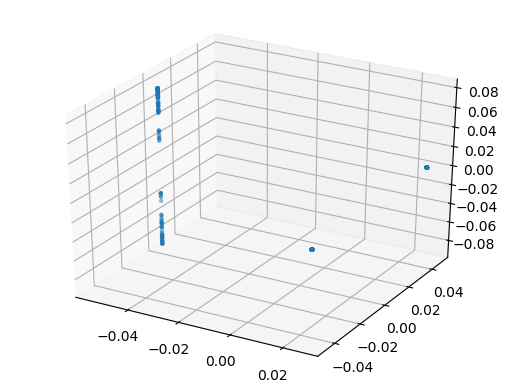

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x00000000564CDB70>

In [201]:
alpha = 0.23 ;
c = 3 ;

Yt2 = DiffMap(data2 , alpha , c) ;
scatter3D(Yt2[:,1] , Yt2[:,2] , Yt2[:,3] , s = 5)

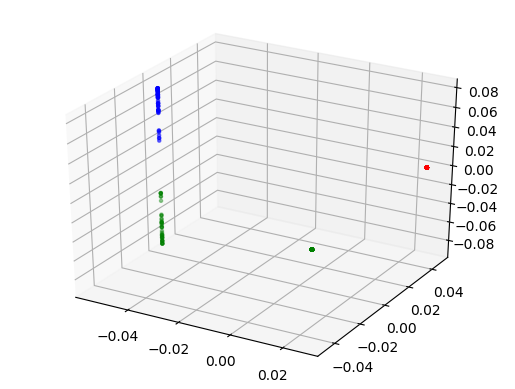

The update times = 2

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x0000000057B437F0>

In [213]:
cluster = 3 ; # seperate into three groups
group , center = k_means(Yt2 , cluster) ;

color = Array{String}(undef, size(group , 1)) ;
for ii = 1 : size(group , 1)
    color[ii] = dict[group[ii]] ;
end
scatter3D(Yt2[:,1] , Yt2[:,2] , Yt2[:,3] , s = 5 , c = color)

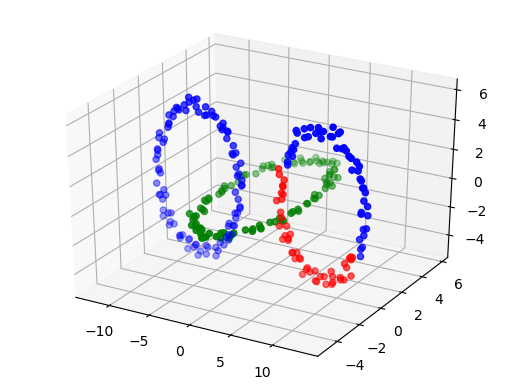

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x00000000565DD668>

In [203]:
scatter3D(data2[:,1] , data2[:,2] , data2[:,3] , s = 20 , c = color)

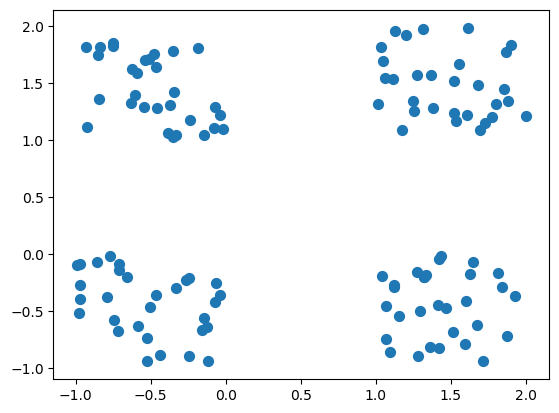

PyObject <matplotlib.collections.PathCollection object at 0x00000000577FE390>

In [204]:
scatter(data3[:,1] , data3[:,2] , s = 50 )

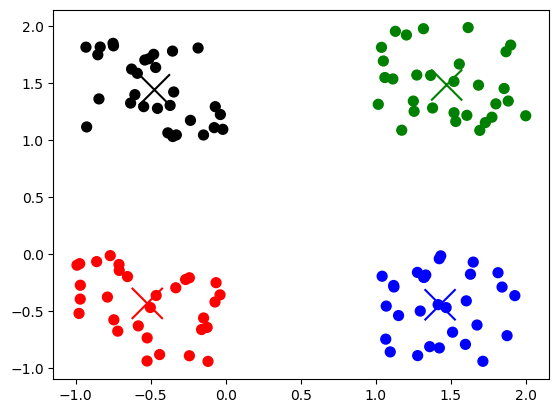

The update times = 2

PyObject <matplotlib.collections.PathCollection object at 0x000000005786E080>

In [205]:
cluster = 4 ; # seperate into three groups
group , center = k_means(data3 , cluster) ;

color = Array{String}(undef, size(group , 1)) ;
for ii = 1 : size(group , 1)
    color[ii] = dict[group[ii]] ;
end

scatter(data3[:,1] , data3[:,2] , s = 50 , c = color)
scatter(center[:,1] , center[:,2] , s = 500 , c = ["red","green","blue","black"],marker = "x")